In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from pprint import pprint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from graphviz import Digraph
from IPython.display import Image, display
from sklearn.metrics import accuracy_score,precision_score,recall_score
%matplotlib inline

In [2]:
df=pd.read_csv("decision-tree.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df = shuffle(df)
data=np.array(df,dtype=float)

In [7]:
np.random.shuffle(data)
training, test = data[:round(len(data)*0.8),:], data[round(len(data)*0.8):,:]
#training, validation = training[:round(len(training)*0.8),:], training[round(len(training)*0.8):,:]

height_of_tree = []
test_cost_at_height = []


In [8]:
def check_purity(data):
    classes = np.unique(data[:,-1])
    if len(classes) == 1:
        return True
    else:
        return False
def majority_class(data):
    classes,count = np.unique(data[:,-1],return_counts = True)
    index = np.argmax(count)
    return classes[index]
def splitting_points(data):
    data = data[:,0:-1]
    points={}
    rows,columns = data.shape
    #print(columns)
    for col in range(columns):
        points[col]=[]
        value = data[:,col]
        unique_points = np.unique(value)
        for i in range(1,len(unique_points),1):
            middle_point = (unique_points[i]+unique_points[i-1])/2
            points[col].append(middle_point)
    return points
def seperate_data(data,c_index,point):
    c_value = data[:,c_index]
    
    left = data[c_value <= point]
    right = data[c_value > point]
    return left,right
    
    

In [9]:
class Node:
    def __init__(self, c_index=None, c_value=None, data_left=None, data_right=None, gain=None, name=None,leaf=None,group=None):
        self.c_index = c_index
        self.c_value = c_value
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.name = name
        self.is_leaf= leaf
        self.group = group

<h1> accuracy functions <h1>

In [10]:
def predict_class(root,test):
    if(root.is_leaf == True):
        return root.group
    if(test[root.c_index] <= root.c_value):
        return predict_class(root.data_left,test)
    else:
        return predict_class(root.data_right,test)

In [11]:
def calulate_metrics(root,test):
    test_x=test[:,:-1]
    test_y=test[:,-1]
    predicted_y = []
    for i in range(len(test)):
        y_p = predict_class(root,test_x[i])
        predicted_y.append(y_p)
    print("accuracy :" + str(accuracy_score(test_y, predicted_y)))
    print("precision_score :" + str(precision_score(test_y, predicted_y,average='macro')))
    print("recall_score :" + str(recall_score(test_y, predicted_y,average='macro')))

def find_accuracy(root,test):
    test_x=test[:,:-1]
    test_y=test[:,-1]
    predicted_y = []
    for i in range(len(test)):
        y_p = predict_class(root,test_x[i])
        predicted_y.append(y_p)
    return (accuracy_score(test_y, predicted_y))
    
    
    

<h1> Entropy calculation <h1>

In [12]:
def find_entropy(data):
    classes,count = np.unique(data[:,-1],return_counts = True)
    probability = count / count.sum()
    probability = probability * np.log2(probability)
    entropy = np.sum(probability) * -1
    return entropy


def split_entropy(left_data,right_data):
    total_data = len(left_data)+len(right_data)
    total_entropy = (len(left_data)/total_data) * find_entropy(left_data)
    total_entropy +=(len(right_data)/total_data) * find_entropy(right_data) 
    return total_entropy

def find_spliting_point(data,split_point):
    min_entropy = 99999
    s_index=-1
    s_value=-1
    for c_index in split_point:
        for value in split_point[c_index]:
            left,right = seperate_data(data,c_index,value)
            cur_entropy = split_entropy(left,right)
            if cur_entropy <=min_entropy:
                min_entropy = cur_entropy
                s_index = c_index
                s_value = value
    return s_index,s_value
                
    
    
    

<h1> creating tree <h1>

In [13]:
def create_tree(data,root,possible_splitting_point):
    if check_purity(data) or len(data) <= 10 or len(possible_splitting_point) == 0:
        root.is_leaf = True
        root.group = majority_class(data)
        return root
    else:
        s_index,s_value = find_spliting_point(data,possible_splitting_point)
        data_left,data_right =  seperate_data(data,s_index,s_value)
        #possible_splitting_point.pop(s_index, None)
        possible_splitting_point[round(s_index)].remove(s_value)
        root.c_index = s_index
        root.c_value = s_value
        root.group = majority_class(data)
        root.name = df.columns[s_index]
        root.is_leaf = False
        left_node = Node()
        right_node = Node()
        left_node = create_tree(data_left,left_node,possible_splitting_point)
        right_node = create_tree(data_right,right_node,possible_splitting_point)
        root.data_left = left_node
        root.data_right = right_node
        return root
        
        
    

<h1> visualize tree <h1>

In [14]:
def visualize_tree(node, graph=None):
    if graph is None:
        graph = Digraph(format='png')
        graph.attr(dpi='200')

    node_label = f"{node.name}\nGroup: {node.group}" if node.is_leaf else f"Feature: {node.name}\nSplit value: {node.c_value}"
    graph.node(str(node), label=node_label)

    if node.data_left and node.is_leaf != True:
        graph.edge(str(node), str(node.data_left), label="Left")
        visualize_tree(node.data_left, graph)

    if node.data_right and node.is_leaf != True:
        graph.edge(str(node), str(node.data_right), label="Right")
        visualize_tree(node.data_right, graph)
    return graph
    





<h1> reduced-error pruning <h1>

In [15]:
def prunning(root,data):
    global Tree
    Tree = root
    def get_height(root):
        if root.is_leaf:
            return 1
        l = get_height(root.data_left)
        r = get_height(root.data_right)
        return max(l,r)+1
    
    def prune_node(node,data):
        if node.is_leaf:
            return node
        prune_node(node.data_left,data)
        prune_node(node.data_right,data)
        
        accuracy_og = find_accuracy(Tree,data)
        node.is_leaf = True
        accuracy_new = find_accuracy(Tree,data)
        
        if(accuracy_og <= accuracy_new):
            height_of_tree.append(get_height(Tree))
            test_cost_at_height.append(accuracy_new)
            print("deleted " + str(node.name) + str(node.c_value))
        else:
            node.is_leaf = False
        return node
    root = prune_node(Tree,data)
    return root
        
        
    
    
        
    

In [16]:
split_points = splitting_points(training)
Root = Node()
Root = create_tree(training,Root,split_points)

<h1> before Prunning <h1>

In [17]:

calulate_metrics(Root,test)

accuracy :0.6883116883116883
precision_score :0.6367924528301887
recall_score :0.6367924528301887



(process:11696): GLib-GIO-WARNING **: 13:08:19.802: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.2.8.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 46 extensions but has no verbs


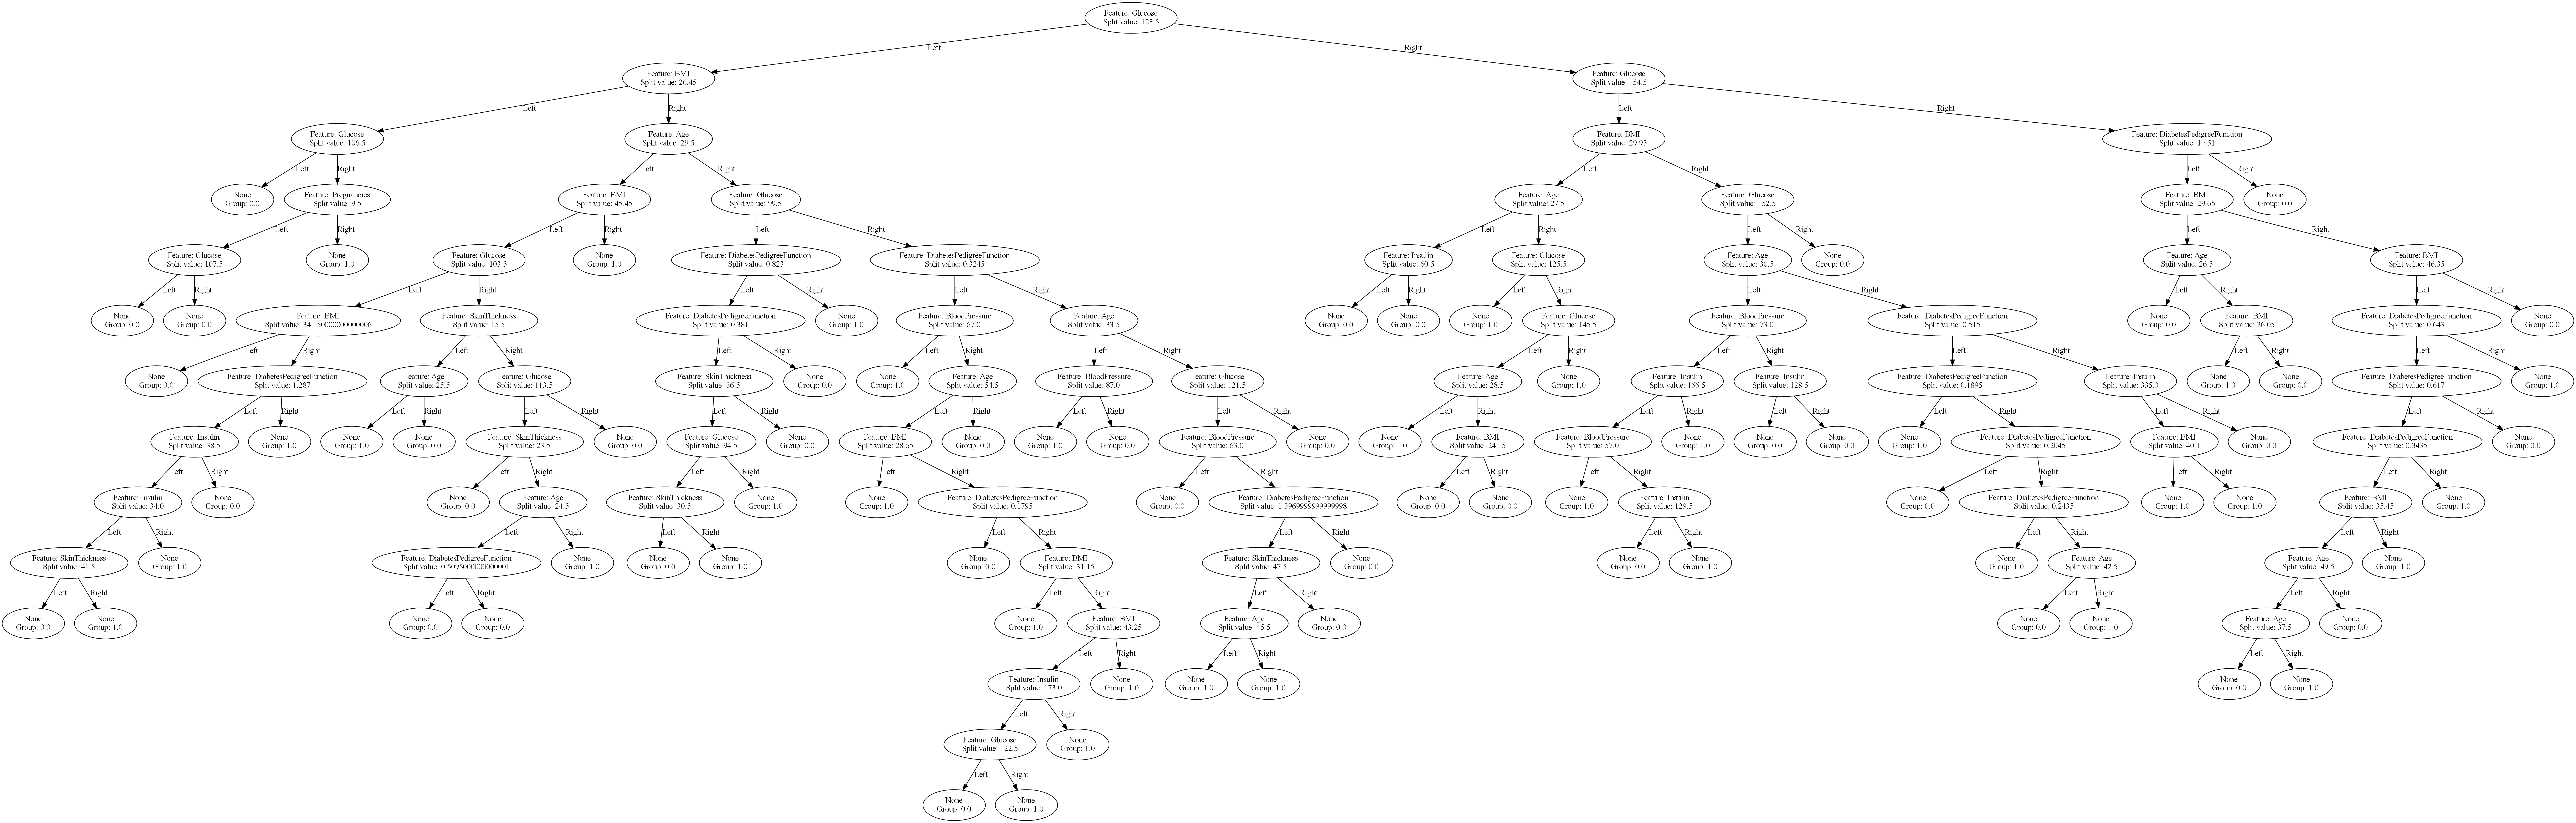

In [18]:
graph = visualize_tree(Root)
# Save the image
graph.render('tree', format='png', cleanup=True)

# Display the saved image inline
display(Image(filename='tree.png'))

<h1> after prunning <h1>

In [19]:
Root = prunning(Root,test)

deleted Glucose107.5
deleted Pregnancies9.5
deleted Glucose106.5
deleted SkinThickness41.5
deleted Insulin34.0
deleted Insulin38.5
deleted DiabetesPedigreeFunction1.287
deleted BMI34.150000000000006
deleted Age25.5
deleted DiabetesPedigreeFunction0.5095000000000001
deleted Age24.5
deleted SkinThickness23.5
deleted Glucose113.5
deleted SkinThickness15.5
deleted Glucose103.5
deleted BMI45.45
deleted SkinThickness30.5
deleted Glucose94.5
deleted SkinThickness36.5
deleted DiabetesPedigreeFunction0.381
deleted DiabetesPedigreeFunction0.823
deleted Glucose122.5
deleted Insulin173.0
deleted BMI43.25
deleted BMI31.15
deleted DiabetesPedigreeFunction0.1795
deleted BMI28.65
deleted Age54.5
deleted BloodPressure67.0
deleted Age45.5
deleted SkinThickness47.5
deleted DiabetesPedigreeFunction1.3969999999999998
deleted BloodPressure63.0
deleted Glucose99.5
deleted Age29.5
deleted BMI26.45
deleted Insulin60.5
deleted BMI24.15
deleted Age28.5
deleted Glucose145.5
deleted Glucose125.5
deleted Age27.5
de

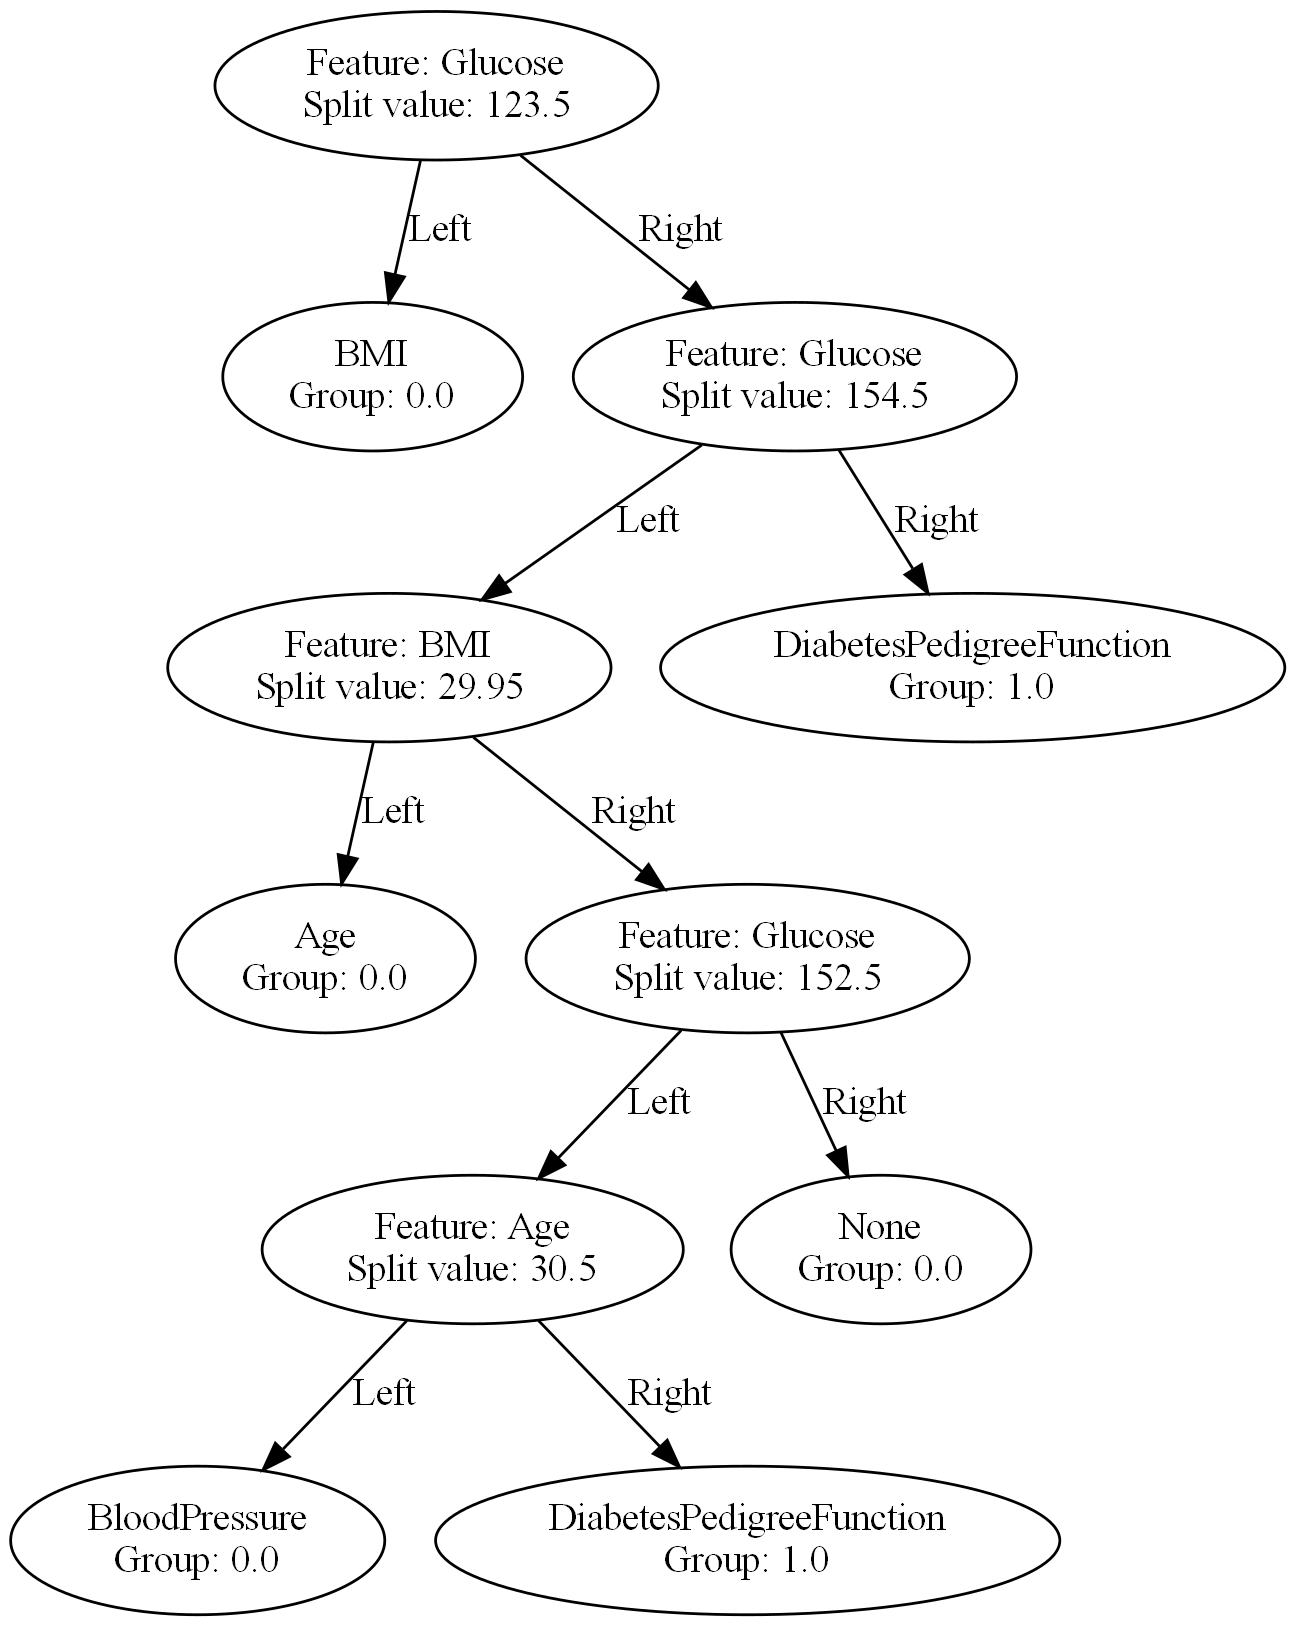

In [20]:
graph = visualize_tree(Root)
# Save the image
graph.render('tree', format='png', cleanup=True)

# Display the saved image inline
display(Image(filename='tree.png'))

In [21]:
calulate_metrics(Root,test)

accuracy :0.7857142857142857
precision_score :0.7605042016806722
recall_score :0.7132468553459119


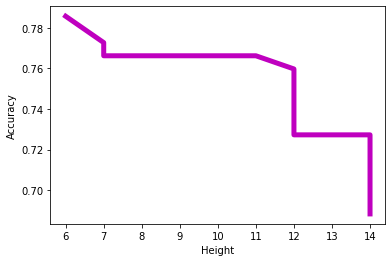

In [22]:
plt.xlabel('Height')
plt.ylabel('Accuracy')
plt.plot(height_of_tree, test_cost_at_height, 'm', linewidth = "5")
plt.show()